# Import libraries

In [1]:
import sys
from pathlib import Path
sys.path.insert(0,'..')
import glob
#!pip install openpyxl

In [2]:
import os
import sys
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import h5py
import re

from functools import partial
from multiprocessing import Pool

from lhcsmapi.Time import Time
from lhcsmapi.Timer import Timer
from lhcsmapi.metadata.MappingMetadata import MappingMetadata
from scipy import signal
import xarray as xr

from src.utils.utils import log_acquisition
from src.utils.hdf_tools import acquisition_to_hdf5, load_from_hdf_with_regex
from src.visualisation.sec_quench_visualisation import plot_wiggle_analysis
from src.modeling.sec_quench import *
from src.utils.dataset_utils import *
from src.utils.utils import interp

pd.set_option('display.max_rows', 200)
import warnings
warnings.filterwarnings('ignore')
#%matplotlib widget
#%matplotlib inline
#%load_ext autoreload

# Define Paths

In [3]:
file_path  = Path('/eos/project/m/ml-for-alarm-system/private/RB_signals')
data_path = file_path / 'backup/20220707_data'
simulation_path = file_path / 'backup/20220707_simulation'

# Read the (clean) MP3 file

In [4]:
mp3_fpa_df = pd.read_csv("../data/RB_TC_extract_2022_07_07_processed_filled.csv")
len(mp3_fpa_df)

3981

# Select events to analyze

In [ ]:
mp3_fpa_df_unique = mp3_fpa_df.drop_duplicates(subset=['timestamp_fgc', 'Circuit Name'])
lower_limit = Time.to_unix_timestamp('2014-01-01 00:00:00+01:00')
mp3_fpa_df_period = mp3_fpa_df_unique[mp3_fpa_df_unique['timestamp_fgc'] >= lower_limit].reset_index(drop=True) 

mp3_fpa_df_period_all = mp3_fpa_df[mp3_fpa_df['timestamp_fgc'] >= lower_limit].reset_index(drop=True) 
print(len(mp3_fpa_df_period), len(mp3_fpa_df_period_all))

In [ ]:
# Add information, whether download was successfull
df_acquisition = pd.read_excel("../data/20220707_acquisition_summary.xlsx")
mp3_fpa_df_period_merged = mp3_fpa_df_period.merge(df_acquisition , left_on=['Circuit Name', 'timestamp_fgc'], right_on=['Circuit Name', 'timestamp_fgc'], how="left")
df_to_analyze = mp3_fpa_df_period_merged[mp3_fpa_df_period_merged['VoltageNQPS.*U_DIODE']==1]
len(df_to_analyze)

# Analyze all events

In [ ]:
fpa_identifier = "RB_RB.A78_1636740012620000000"    
circuit_name = fpa_identifier.split("_")[1]
timestamp_fgc = int(fpa_identifier.split("_")[2])

mp3_fpa_df_subset = mp3_fpa_df[(mp3_fpa_df.timestamp_fgc == timestamp_fgc) & 
                               (mp3_fpa_df['Circuit Name'] == circuit_name)]

In [ ]:
all_quenched_magnets = mp3_fpa_df_subset.Position.values
quench_times = mp3_fpa_df_subset["Delta_t(iQPS-PIC)"].values /1e3
        
# load data
data_dir = data_path / (fpa_identifier + ".hdf5")
data = load_from_hdf_with_regex(file_path=data_dir, regex_list=['VoltageNQPS.*U_DIODE'])
df_data = u_diode_data_to_df(data, len_data=len(data[0]))

# load simulation 
simulation_dir = simulation_path / (fpa_identifier + ".hdf")
data_sim = load_from_hdf_with_regex(file_path=simulation_dir, regex_list=["0v_magf"])
df_sim = u_diode_simulation_to_df(data_sim, circuit_name=circuit_name)

# save magnet order for later useage
magnet_list=df_sim.columns
                        
# drop quenched magnet
max_time = df_data.index.max()
df_data_noq = drop_quenched_magnets(df_data, all_quenched_magnets, quench_times, max_time)
df_sim_noq = drop_quenched_magnets(df_sim, all_quenched_magnets, quench_times, max_time)

# sometimes only noise is stored, mean must be in windwo -1, -10
df_data_noq = df_data_noq.drop(df_data_noq.columns[~(-1>df_data_noq.mean()) & (-10<df_data_noq.mean())], axis=1)

# align 
t_first_extraction = min(float(mp3_fpa_df_subset['Delta_t(EE_odd-PIC)'].values[0]) / 1000, 
                         float(mp3_fpa_df_subset['Delta_t(EE_even-PIC)'].values[0]) / 1000)
t_first_extraction = get_u_diode_data_alignment_timestamps(df_sim_noq)
df_data_aligned = align_u_diode_data(df_data_noq.copy(), t_first_extraction)

# cut out time frame to analyze, [-0.25, 1] is 1336 samples
time_frame = [-0.25, 1]
df_data_cut = df_data_aligned[(time_frame[0] <= df_data_aligned.index) & (time_frame[1] >= df_data_aligned.index)]

# adjust simulation length to data 
df_sim_noq_resampled = interp(df_sim_noq, df_data_cut.index)

# add quenched magnets again for continuity
dropped_columns_data = magnet_list[~magnet_list.isin(df_data_cut.columns)]
dropped_columns_simulation = magnet_list[~magnet_list.isin(df_sim_noq_resampled.columns)]
df_data_cut[dropped_columns_data] = np.nan
df_sim_noq_resampled[dropped_columns_simulation] = np.nan
# bring into electrical order again
df_data_cut = df_data_cut[magnet_list]
df_sim_noq_resampled = df_sim_noq_resampled[magnet_list]


In [ ]:
df_data_cut.plot(legend=False) 

In [ ]:
df_data_cut.plot(legend=False) 
ee_odd = float(mp3_fpa_df_subset['Delta_t(EE_odd-PIC)'].values[0]) / 1000
ee_even = float(mp3_fpa_df_subset['Delta_t(EE_even-PIC)'].values[0]) / 1000

plt.axvline(x=ee_odd)
plt.axvline(x=ee_even)

In [ ]:
df_sim_noq_resampled.plot(legend=False) 
ee_odd = float(mp3_fpa_df_subset['Delta_t(EE_odd-PIC)'].values[0]) / 1000
ee_even = float(mp3_fpa_df_subset['Delta_t(EE_even-PIC)'].values[0]) / 1000

plt.axvline(x=ee_odd)
plt.axvline(x=ee_even)

# Get all events

In [7]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


from src.dataset import load_dataset
from src.datasets.rb_fpa_prim_quench_ee_plateau import RBFPAPrimQuenchEEPlateau
from src.datasets.rb_fpa_full_quench import RBFPAFullQuench

/cvmfs/sft.cern.ch/lcg/views/LCG_100_nxcals/x86_64-centos7-gcc9-opt/lib/python3.8/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/cvmfs/sft.cern.ch/lcg/views/LCG_100_nxcals/x86_64-centos7-gcc9-opt/lib/python3.8/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details a

In [8]:
dataset_path = Path("/eos/project/m/ml-for-alarm-system/private/RB_signals/backup/20220707_prim_ee_plateau_dataset")
plot_dataset_path = Path("/eos/project/m/ml-for-alarm-system/private/RB_signals/backup/20220707_prim_ee_plateau_plots")

context_path = Path("../data/RB_TC_extract_2022_07_07_processed_filled.csv")
acquisition_summary_path = Path("../data/20220707_acquisition_summary.xlsx")
data_path = Path("/eos/project/m/ml-for-alarm-system/private/RB_signals/backup/20220707_data")
simulation_path = Path("/eos/project/m/ml-for-alarm-system/private/RB_signals/backup/20220707_simulation")
metadata_path = Path("../data/RB_metadata.csv")

In [9]:
ds = RBFPAPrimQuenchEEPlateau(dataset_path=dataset_path,
             context_path=context_path,
             metadata_path=metadata_path,
             data_path=data_path,
             simulation_path=simulation_path,
             acquisition_summary_path=acquisition_summary_path,
             plot_dataset_path=plot_dataset_path)

fpa_identifiers = ds.select_events()

dataset = ds.load_dataset(fpa_identifiers=fpa_identifiers, 
                          dataset_path=dataset_path, 
                          drop_data_vars=['simulation','el_position_feature','event_feature'])

In [10]:
mp3_fpa_df_in_dataset = mp3_fpa_df_period[mp3_fpa_df_period.fpa_identifier.isin(dataset.event.values)]
mp3_fpa_df_in_dataset["first_exrtraction"] = [min(float(row['Delta_t(EE_odd-PIC)']) / 1000, float(row['Delta_t(EE_even-PIC)']) / 1000) for i, row in mp3_fpa_df_in_dataset.iterrows()]

NameError: name 'mp3_fpa_df_period' is not defined

In [12]:
i = 0
max_deviation = np.zeros(len(mp3_fpa_df_in_dataset))
for k, row in mp3_fpa_df_in_dataset.iterrows():

    d = dataset['data'].loc[{'event': row['fpa_identifier']}]#, 'time':slice(t_ee1 + window[0],t_ee1+ window[1])}]
    d = pd.DataFrame(d.values.T, index=d.time.values).rolling(20).mean()
  
    max_deviation[i] = max(abs(d.min().min() - d.mean().mean()), abs(d.max().max() - d.mean().mean()))
    
    if max_deviation[i] > 1.5:
        plt.figure()
        plt.title(f"{row['Timestamp_PIC']}\ndV: {max_deviation[i]:.2f}V")
        plt.tight_layout()
        plt.xlabel('Time / s')
        plt.ylabel('Voltage / V')
        print(row['fpa_identifier'])
        plt.plot(d.index.values, d.values)
        
    i+=1

NameError: name 'mp3_fpa_df_in_dataset' is not defined

In [ ]:
plt.figure(figsize=(12,7))
plt.plot(np.sort(max_deviation)[::-1])
plt.title('Deviation from mean after first EE')
plt.xlabel("Number of events")
plt.ylabel("Voltage / V")
plt.ylim((0,2))
plt.grid()

# fft

In [13]:
dataset_scaled = dataset.copy(deep=True)
dataset_scaled = ds.train_valid_test_split(dataset=dataset_scaled)
dataset_scaled = ds.scale_dataset(dataset=dataset_scaled)

In [54]:
from scipy import signal
from scipy.fft import fft, fftfreq, rfft

def complex_to_polar(x):
    amplitude = np.abs(x)
    phase = np.arctan2(np.imag(x), np.real(x))  # *180/np.pi
    return amplitude, phase

def get_fft_amplitude(x):
    N = len(x)
    y_FFT = fft(np.nan_to_num(x))
    if np.isnan(x).all():
        y_FFT = np.zeros_like(y_FFT) * np.nan
    return 2.0 / N * np.abs(y_FFT[0:N // 2])

def get_fft_phase(DC_Down_data):
    N = len(DC_Down_data)
    x = fft(DC_Down_data)
    return np.arctan2(np.imag(x), np.real(x))[0:N // 2]

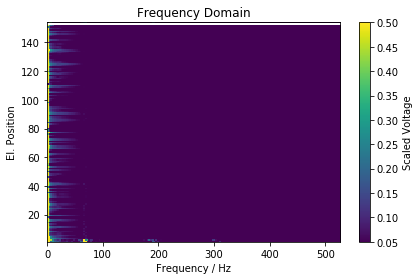

In [55]:
x_time = dataset_scaled[{'event': 0}].data.values
x_fft = np.array([get_fft_amplitude(x) for x in x_time])
dt= dataset[{'event': 0}].time[1].values -dataset[{'event': 0}].time[0].values
frequzency = fftfreq(len(x_time), dt)[:len(x_time)//2]  


fig, ax = plt.subplots()
#x_fft=x_fft.max(axis=0, keepdims=True)*np.ones((154,171))
im = ax.imshow(x_fft, extent=[0,frequzency.max(),1,154], aspect='auto', vmin=0.05, vmax=0.5)
ax.set_xlabel('Frequency / Hz')
ax.set_ylabel('El. Position')
plt.title('Frequency Domain')

#cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
cbar = fig.colorbar(im)
cbar.set_label('Scaled Voltage')

plt.tight_layout()

In [56]:
x_fft

array([[7.8735925e-02, 6.9973558e-01, 3.7693071e-01, ..., 2.6171773e-03,
        2.6226614e-03, 3.3519373e-03],
       [          nan,           nan,           nan, ...,           nan,
                  nan,           nan],
       [8.9702374e-01, 3.6197814e-01, 2.1635249e-01, ..., 3.5290651e-03,
        2.7110297e-03, 1.6362888e-03],
       ...,
       [3.6111689e+00, 8.5047299e-01, 2.5714049e-01, ..., 9.9018449e-03,
        1.3914716e-02, 1.0288175e-02],
       [9.1960162e-01, 7.8724802e-01, 4.4698063e-01, ..., 5.1516648e-03,
        1.6179936e-02, 4.5767496e-03],
       [1.7608771e+00, 7.0881212e-01, 2.0888713e-01, ..., 1.3267497e-02,
        1.1375637e-02, 8.3314050e-03]], dtype=float32)

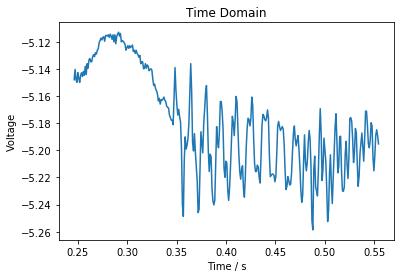

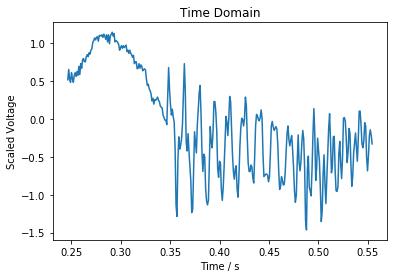

ValueError: x and y must have same first dimension, but have shapes (77,) and (171,)

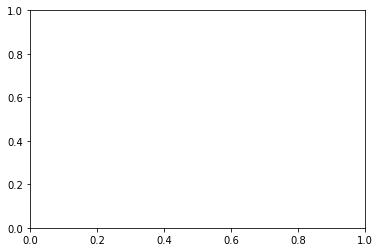

In [57]:

plt.plot(dataset[{'event': 0}].time.values, dataset[{'event': 0}].data.values[0])
plt.title('Time Domain')
plt.ylabel('Voltage')
plt.xlabel('Time / s')
plt.show()

plt.plot(dataset[{'event': 0}].time.values, x_time[0])
plt.title('Time Domain')
plt.ylabel('Scaled Voltage')
plt.xlabel('Time / s')
plt.show()
 
plt.plot(frequzency, x_fft[0])
plt.title('Frequency Domain')
plt.xlabel('Frequency / Hz')

plt.ylabel('Scaled Voltage')
plt.show()

In [58]:
dataset_fft = xr.apply_ufunc(get_fft_amplitude, 
                             dataset_scaled.data,
                             input_core_dims=[['time']], 
                             output_core_dims=[['frequency']], 
                             exclude_dims=set(("time",)),
                             vectorize=True)

In [59]:
np.shape(dataset_fft.values.reshape(len(dataset_fft.event),-1))

(560, 26334)

# 2D-tSNE

# look for concepts

In [60]:
metadata_path = Path("../data/RB_metadata.csv")
rb_magnet_metadata = pd.read_csv(metadata_path)

In [77]:
rb_magnet_metadata

,Unnamed: 0,Circuit,Magnet,Position,B1_aperture,Diode_type,Correctors,EE place,#Electric_EE,#Electric_circuit,Cryostat,Cryostat2,Name,R_1,R_2,RRR_1,RRR_2
0,0,RB.A12,MB.A8R1,276.7340,EXT,R,A,EVEN,1,78,LBARE.8R1,LBARE_08R1,A8R1,1.80,1.85,95.650088,94.103943
1,1,RB.A12,MB.B8R1,292.3940,EXT,R,B,ODD,77,77,LBBRF.8R1,LBBRF_08R1,B8R1,1.67,1.85,100.314516,94.103943
2,2,RB.A12,MB.A9R1,315.7990,EXT,R,A,EVEN,2,79,LBARE.9R1,LBARE_09R1,A9R1,1.75,1.85,97.936878,94.103943
3,3,RB.A12,MB.B9R1,331.4590,EXT,R,B,ODD,76,76,LBBRG.9R1,LBBRG_09R1,B9R1,1.67,1.77,100.314516,97.371760
4,4,RB.A12,MB.A10R1,356.2640,EXT,R,A,EVEN,3,80,LBARE.10R1,LBARE_10R1,A10R1,1.67,1.67,100.314516,100.314516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1227,1227,RB.A81,MB.A10L1,26302.6192,INT,L,B,ODD,75,75,LBBLG.10L1,LBBLG_10L1,A10L1,2.53,3.13,78.314002,70.353447
1228,1228,RB.A81,MB.B9L1,26327.4242,INT,L,A,EVEN,2,79,LBALE.9L1,LBALE_09L1,B9L1,3.25,3.70,68.099268,54.735949
1229,1229,RB.A81,MB.A9L1,26343.0842,INT,L,B,ODD,76,76,LBBLF.9L1,LBBLF_09L1,A9L1,3.09,1.75,70.748254,99.628927
1230,1230,RB.A81,MB.B8L1,26366.4892,INT,L,A,EVEN,1,78,LBALE.8L1,LBALE_08L1,B8L1,2.43,2.43,79.915648,79.899869


Text(0, 0.5, 'El. Position')

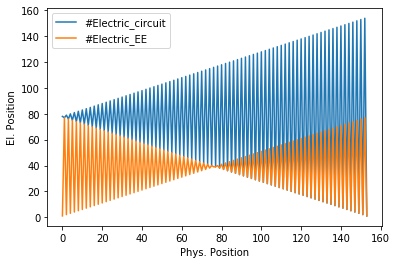

In [81]:
rb_magnet_metadata[rb_magnet_metadata['Circuit'] == 'RB.A12'][['#Electric_circuit','#Electric_EE']].plot()
plt.xlabel('Phys. Position')
plt.ylabel('El. Position')

In [75]:
rb_magnet_metadata[rb_magnet_metadata['Circuit'] == 'RB.A12'][['Position','#Electric_circuit']]

,Position,#Electric_circuit
0,276.7340,78
1,292.3940,77
2,315.7990,79
3,331.4590,76
4,356.2640,80
5,371.9240,75
6,395.3290,81
7,410.9890,74
8,448.1107,82
9,463.7707,73


In [62]:
use_fft = 'max'
if use_fft == 'stack':
    X_input_tsne = dataset_fft.values.reshape(len(dataset_fft.event),-1)
elif use_fft == 'max':
    X_input_tsne = np.nan_to_num(dataset_fft.max(dim=['el_position']).values)
else:
    X_input_tsne = np.nan_to_num(dataset_scaled.data.values.reshape(len(dataset_scaled.event),-1))
    
X_embedded = TSNE(n_components=2, init='pca').fit_transform(X_input_tsne)

/cvmfs/sft.cern.ch/lcg/views/LCG_100_nxcals/x86_64-centos7-gcc9-opt/lib/python3.8/site-packages/sklearn/manifold/t_sne.py:344: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  error = np.finfo(np.float).max
/cvmfs/sft.cern.ch/lcg/views/LCG_100_nxcals/x86_64-centos7-gcc9-opt/lib/python3.8/site-packages/sklearn/manifold/t_sne.py:345: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/rele

In [63]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(X_embedded)
centers = kmeans.cluster_centers_

center_indices=[]

for i, center in enumerate(centers):
    distance = np.linalg.norm(X_embedded - centers[i:i + 1, :], axis=1)
    center_indices.append(np.argsort(distance)[0])

/cvmfs/sft.cern.ch/lcg/views/LCG_100_nxcals/x86_64-centos7-gcc9-opt/lib/python3.8/site-packages/sklearn/cluster/k_means_.py:440: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  centers, labels, n_iter = k_means_elkan(X, checked_sample_weight,
/cvmfs/sft.cern.ch/lcg/views/LCG_100_nxcals/x86_64-centos7-gcc9-opt/lib/python3.8/site-packages/sklearn/cluster/k_means_.py:440: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When repl

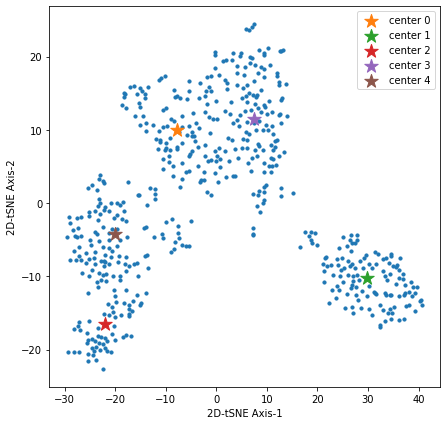

In [64]:
plt.figure(figsize=(7,7))
#plt.grid()

plt.scatter(x=X_embedded[:,0], y=X_embedded[:,1], s=10)
for i, center in enumerate(centers):
    plt.scatter(x=center[0], y=center[1], label=f"center {i}", s=200, marker='*')
    
plt.xlabel('2D-tSNE Axis-1')
plt.ylabel('2D-tSNE Axis-2')
plt.legend()
plt.show()

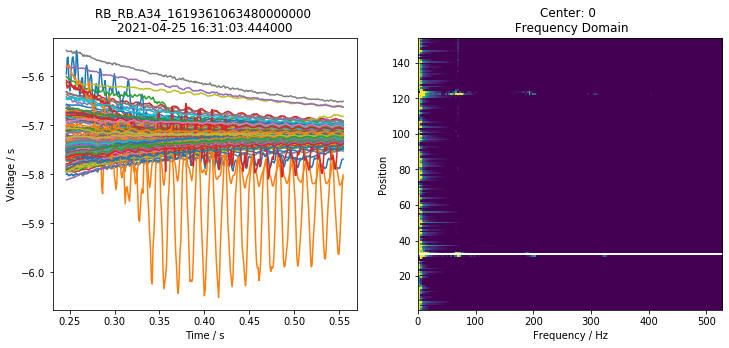

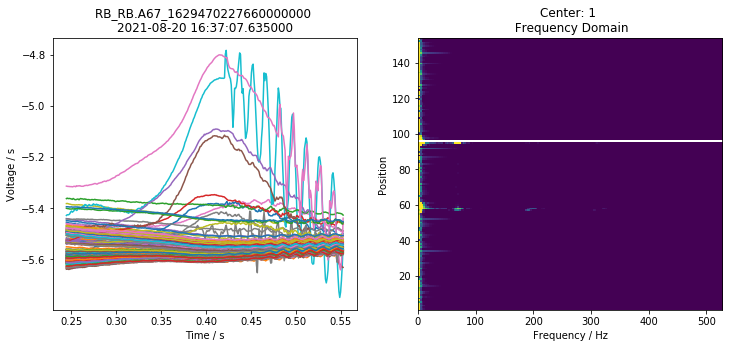

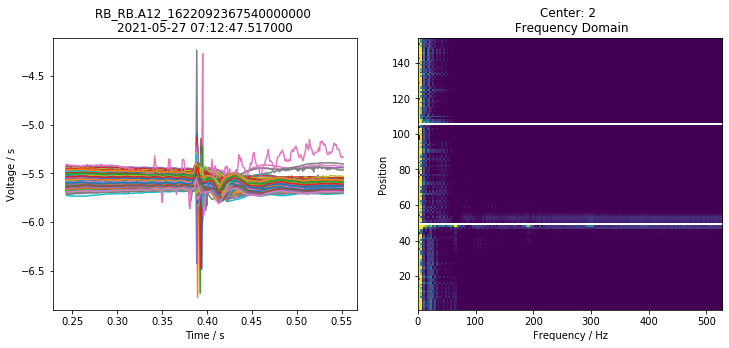

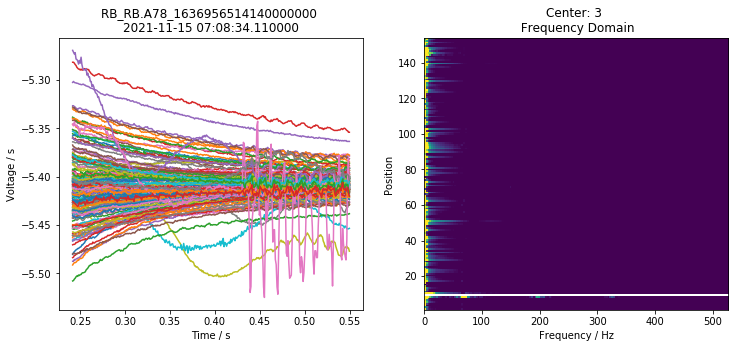

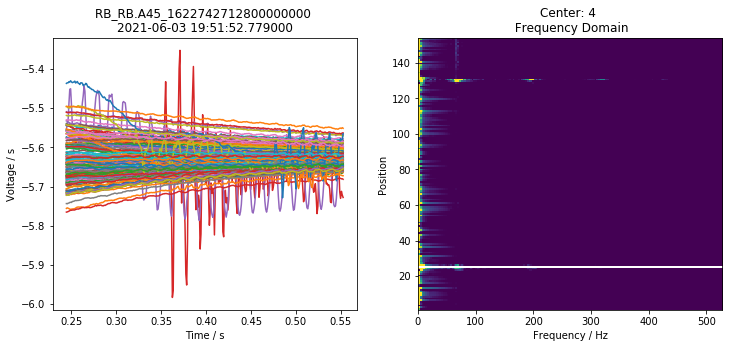

In [82]:
for i, center_indice in enumerate(center_indices):
    fig, ax = plt.subplots(1,2, figsize=(12,5))
    ax[0].plot(dataset[{'event': center_indice}].time, dataset[{'event': center_indice}].data.T)
    fpa_identifier =  dataset[{'event': center_indice}].event.values
    date = mp3_fpa_df[mp3_fpa_df['fpa_identifier'] == fpa_identifier]['Timestamp_PIC'].values[0]
    ax[0].set_title(f"{fpa_identifier} \n{date}")
    ax[0].set_xlabel('Time / s')
    ax[0].set_ylabel('Voltage / s')
    
    im = ax[1].imshow(dataset_fft[{'event': center_indice}], extent=[0,frequzency.max(),1,154], aspect='auto', vmin=0.05, vmax=0.5)
    ax[1].set_xlabel('Frequency / Hz')
    ax[1].set_ylabel('Position')
    ax[1].set_title(f'Center: {i} \n Frequency Domain')

    plt.show()